<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab    


*Authors:*  
 - Joseph Nelson (DC)        
 - Boom Devahastin Na Ayudhya (NYC)     
 - Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')

# Change date column to be datetime dtype
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


In [3]:
data.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [4]:
store1 = data[data['Store'] == 1]
weekly_sales = store1.resample("W").mean()

#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

In [5]:
weekly_sales.head(3)

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-07,1.0,43.616438,22516.313699,False
2010-02-14,1.0,43.569444,22804.964444,True
2010-02-21,1.0,43.616438,22081.755753,False


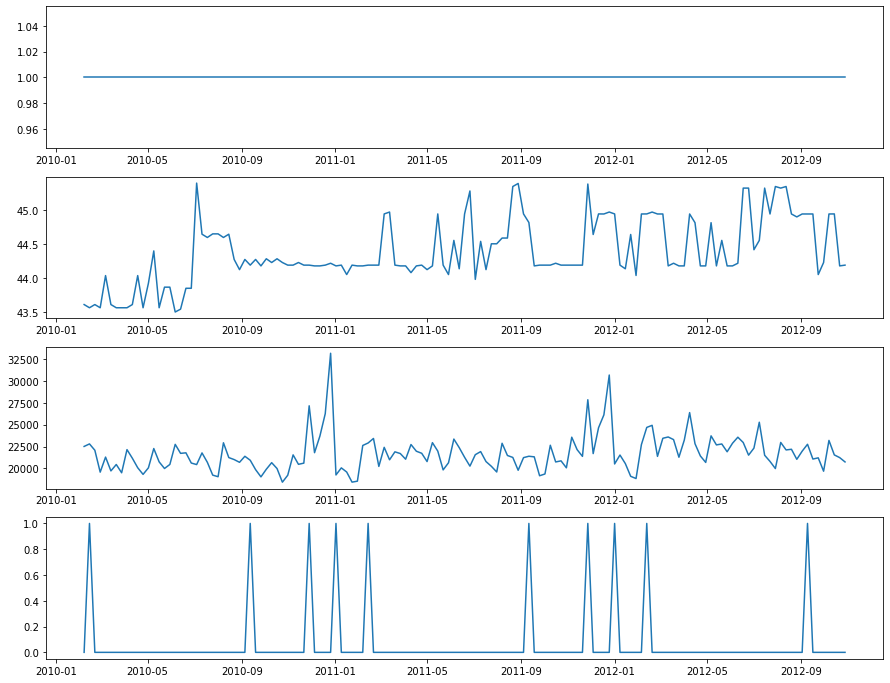

In [6]:
fig, axes = plt.subplots(nrows=4, figsize=(15,12))
axes[0].plot(weekly_sales['Store'])
axes[1].plot(weekly_sales['Dept'])
axes[2].plot(weekly_sales['Weekly_Sales'])
axes[3].plot(weekly_sales['IsHoliday'])

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

In [7]:
weekly_sales['ma4'] = weekly_sales['Weekly_Sales'].rolling(window=4).mean()
weekly_sales['ma13'] = weekly_sales['Weekly_Sales'].rolling(window=13).mean()
weekly_sales['ma52'] = weekly_sales['Weekly_Sales'].rolling(window=52).mean()

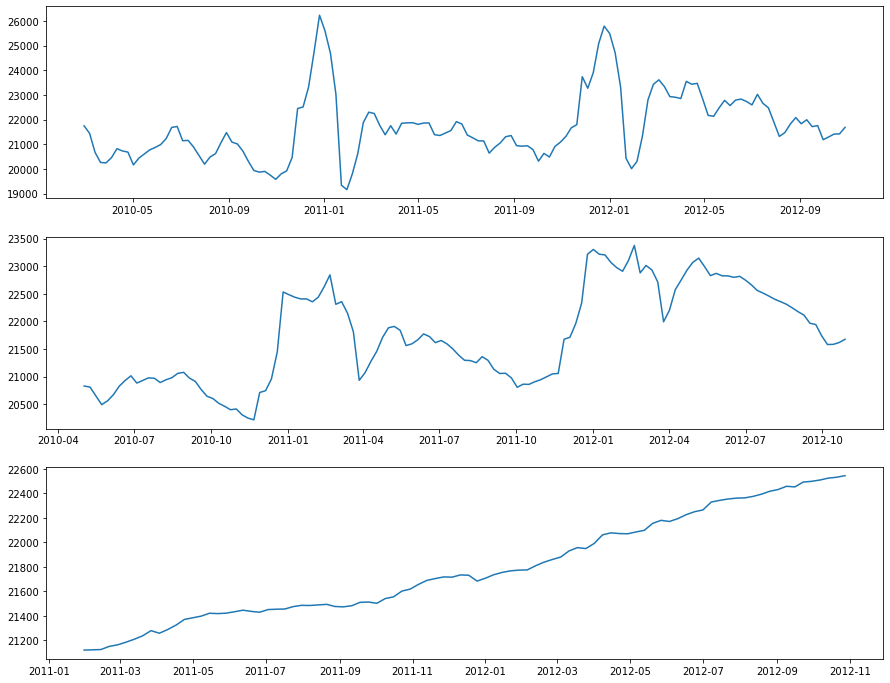

In [8]:
fig, axes = plt.subplots(nrows=3, figsize=(15,12))
axes[0].plot(weekly_sales['ma4'])
axes[1].plot(weekly_sales['ma13'])
axes[2].plot(weekly_sales['ma52']);

**2c. What can you say about patterns in the data based on the rolling mean plot above?**

There is seasonality at the weekly and quarterly level, but the data becomes stationary at the year time frame. 

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [9]:
def acf(periods):
    plot_acf(weekly_sales['Weekly_Sales'], lags = periods)
    
def pacf(periods):
    plot_pacf(weekly_sales['Weekly_Sales'], lags = periods);

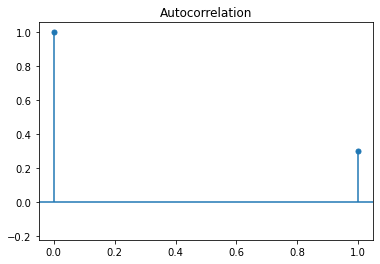

In [10]:
acf(1)

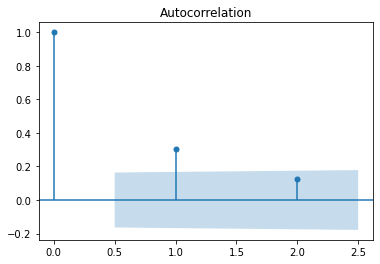

In [11]:
acf(2)

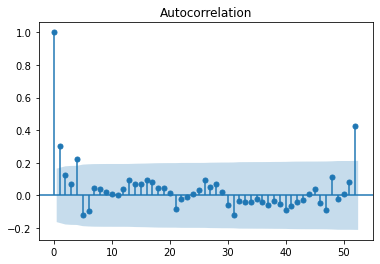

In [12]:
acf(52)

**3b. What can you say about the series based on these autocorrelations?**

Answer: The most recent time period is the most important in telling the next time period when it comes to Weekly Sales. 

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

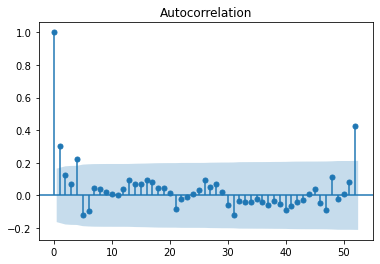

In [13]:
acf(52)

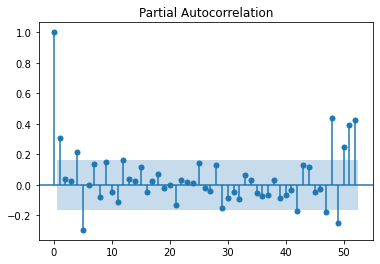

In [14]:
pacf(52)

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer: The latest and year offset data are the most valueable when it comes to telling Weekly Sales. This may suggest some seasonality, perhaps something akin to increased sales around holidays? These graphs also tell me that the the middle ground when it comes to data is not extremely useful in telling me about this most current Weekly Sales

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer: I will need to remove stationarity from data and creating rolling average for the most recent timeframe along with a year long lag could be useful in modeling. 

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data. You can do this using `train_test_split` with a specific parameter, or can manually define it how it is set up below.

In [15]:
weekly_sales['lag_1'] = weekly_sales['Weekly_Sales'].shift(1)
weekly_sales['lag_52'] = weekly_sales['Weekly_Sales'].shift(52)

In [16]:
# Generate train/test split.
y_train, y_test = train_test_split(weekly_sales['Weekly_Sales'],
                                                    test_size = 0.2,
                                                      shuffle=False)

In [17]:
# train = 

# test =

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [18]:
def arima(p,d,q, data):
    
    y_train, y_test = train_test_split(data,
                                                    test_size = 0.2,
                                                      shuffle=False)
    
    arima = ARIMA(endog=y_train.astype(float).dropna(),
                                              order =(p,d,q))
    model = arima.fit()
    
    preds = model.predict(   start=y_train.index[0],
                         end=y_train.index[-1])
    
    mse = mean_squared_error(y_true=y_train, y_pred=preds)
    
    residuals = y_train-preds
    plt.scatter(residuals, preds)
    plt.show()
    
    return f'Model Mean Squared Error: {np.round(mse,2)}', plt.show()

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


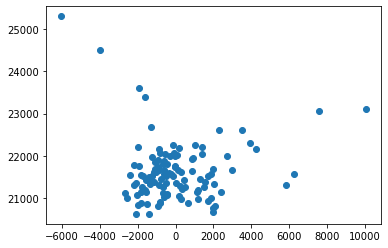

('Model Mean Squared Error: 4648867.01', None)

In [19]:
arima(1,0,0, weekly_sales['Weekly_Sales'])

**6c. How effective do you think this `AR(1)` model is?**

Answer: I don't think it is very effective. That is quite a large MSRE. 

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

In [20]:
# See above function

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer:

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

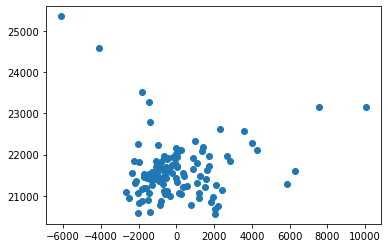

('Model Mean Squared Error: 4638295.62', None)

In [21]:
arima(2,0,0, weekly_sales['Weekly_Sales'])

**8b. How did your results change?**

Answer: Very slightly better, but nothing to write home about.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

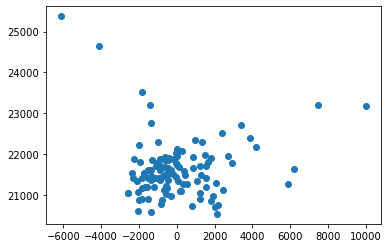

('Model Mean Squared Error: 4629474.23', None)

In [22]:
arima(2,0,2, weekly_sales['Weekly_Sales'])

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer: Very slowly improving on our original results.

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [23]:
#credit hov
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [24]:
# Run ADF test on original (non-differenced!) data.
adf_test(weekly_sales['Weekly_Sales'])

Results of Dickey-Fuller Test:
Test Statistic                  -5.109956
p-value                          0.000013
#Lags Used                       4.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64


**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer: I am little confused that this data appears to pass the ADF test. The p-value is very small, which is usually a clue we can reject the null hypothesis and accept that the data is stationary. 

#### 10. Differenced Data

Regardless of what you found above, now we're going to take a look at differenced data.

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [25]:
# one diff
weekly_sales['Weekly_Sales_diff1'] = weekly_sales['Weekly_Sales'].diff(1)
# two diff
weekly_sales['Weekly_Sales_diff2'] = weekly_sales['Weekly_Sales'].diff(2)
#three diff
weekly_sales['Weekly_Sales_diff3'] = weekly_sales['Weekly_Sales'].diff(3)
# four diff
weekly_sales['Weekly_Sales_diff4'] = weekly_sales['Weekly_Sales'].diff(4)

In [26]:
weekly_sales.dropna(inplace=True)

**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [27]:
adf_test(weekly_sales['Weekly_Sales_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                -5.807119e+00
p-value                        4.489515e-07
#Lags Used                     7.000000e+00
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


In [28]:
adf_test(weekly_sales['Weekly_Sales_diff2'])

Results of Dickey-Fuller Test:
Test Statistic                 -4.455006
p-value                         0.000237
#Lags Used                      9.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [29]:
adf_test(weekly_sales['Weekly_Sales_diff3'])

Results of Dickey-Fuller Test:
Test Statistic                 -4.651796
p-value                         0.000104
#Lags Used                     10.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


In [30]:
adf_test(weekly_sales['Weekly_Sales_diff4'])

Results of Dickey-Fuller Test:
Test Statistic                 -5.112543
p-value                         0.000013
#Lags Used                      7.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [31]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(25,5))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

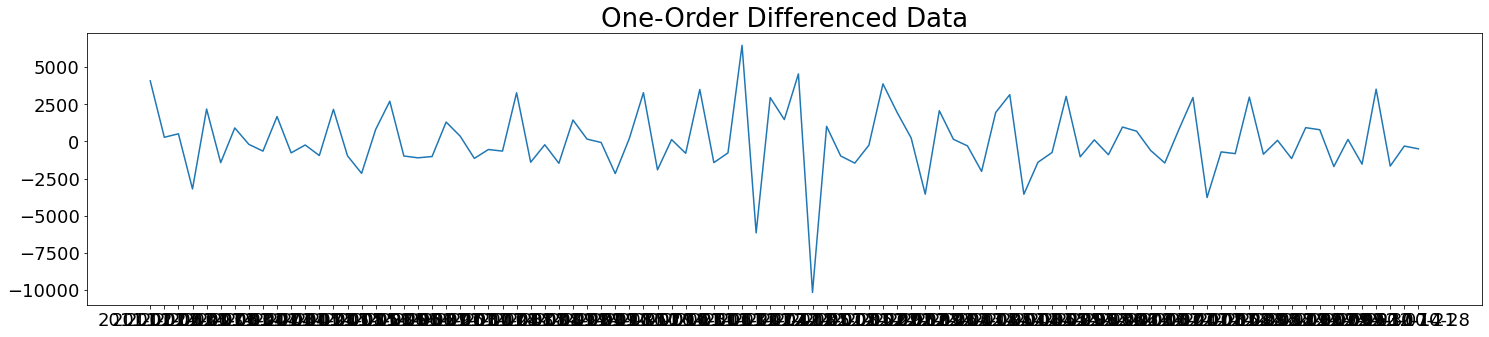

In [32]:
plot_series(weekly_sales, ['Weekly_Sales_diff1'], title='One-Order Differenced Data')

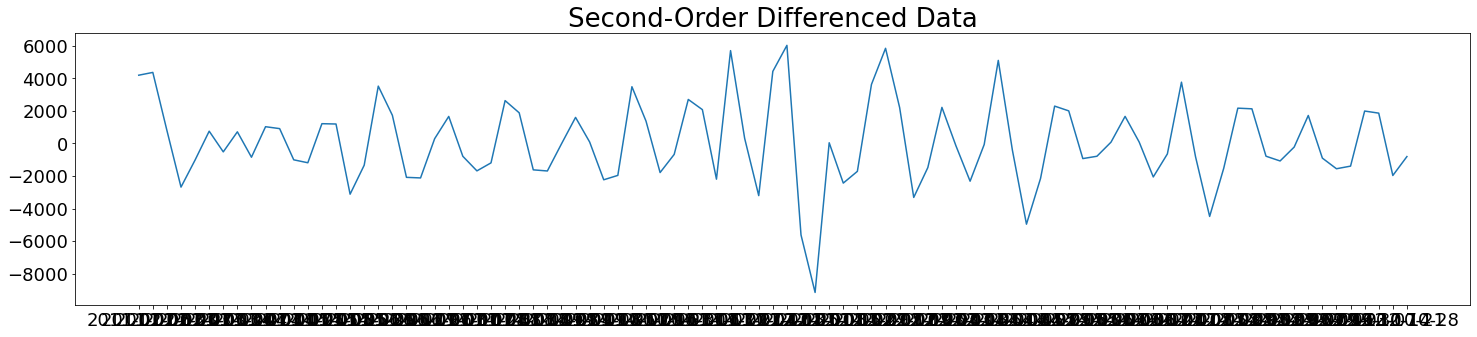

In [33]:
plot_series(weekly_sales, ['Weekly_Sales_diff2'], title='Second-Order Differenced Data')

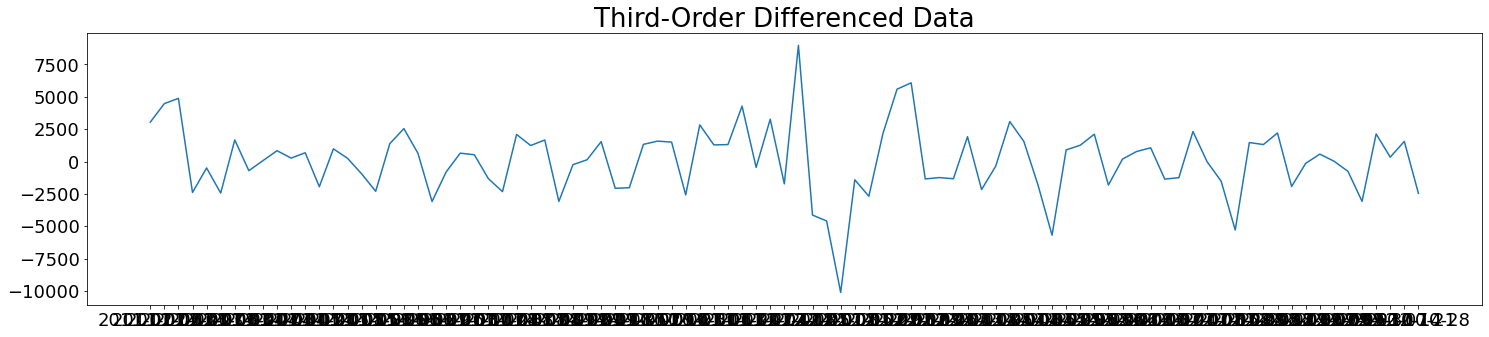

In [34]:
plot_series(weekly_sales, ['Weekly_Sales_diff3'], title='Third-Order Differenced Data')

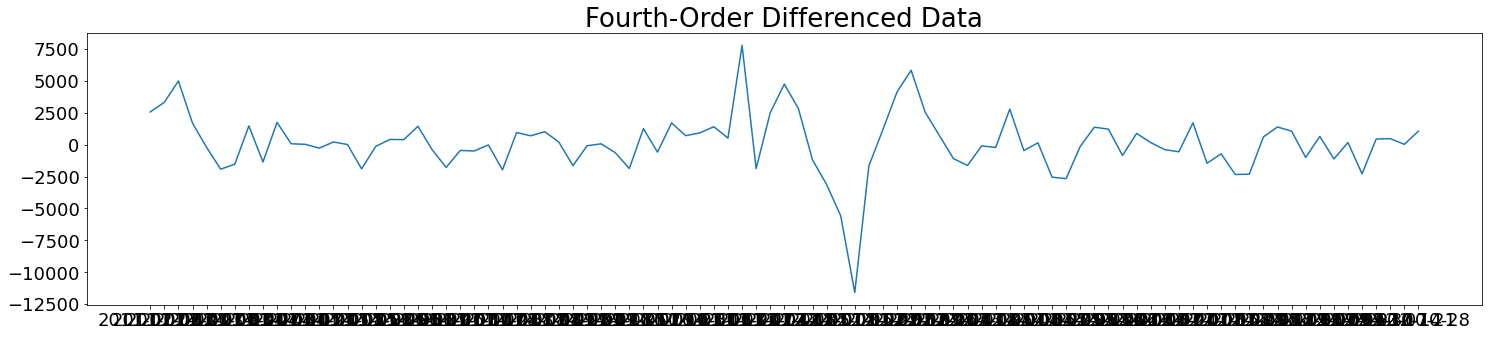

In [35]:
plot_series(weekly_sales, ['Weekly_Sales_diff4'], title='Fourth-Order Differenced Data')

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer: The more differencing that is done the more the test results improve and the data appears to become increasingly more stationary. 

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer: I think that we will miss much of the seasonal trends so the model will be only so useful. 

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Using whichever metric(s) you think best suit this problem (don't forget to import them above!), evaluate your model on the training and testing sets and generate a residual plot.**

In [55]:
arima = ARIMA(endog=y_train.astype(float).dropna(),
                                              order =(2,1,2))

model = arima.fit()

preds = model.predict(start=y_test.index[0],
                         end=y_test.index[-1])

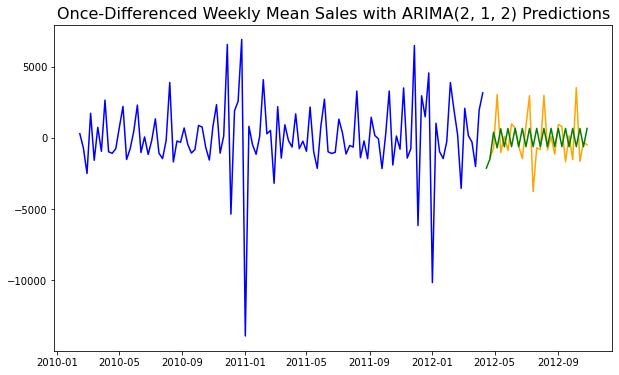

In [56]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Once-Differenced Weekly Mean Sales with ARIMA(2, 1, 2) Predictions', fontsize=16)
plt.show();

**11b. Interpret the results from the last answer.**


Answer: Looks like it is tracking along the mean and missing all seasonal trends. Also not a good thing that the residuals do not appear to be random.

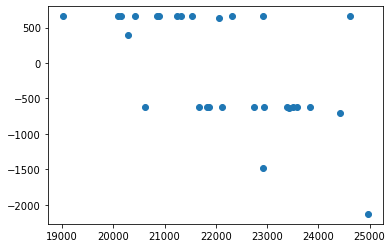

'Model Mean Squared Error: 491592499.24'

In [61]:
mse = mean_squared_error(y_true=y_test, y_pred=preds)
    
residuals = y_test-preds
plt.scatter(residuals, preds)
plt.show()
f'Model Mean Squared Error: {np.round(mse,2)}'

#### 12.  BONUS [12a-12b]: SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

**12b. How did your best SARIMAX model perform?**

Answer:

### 13. Your Best Model

In [72]:
#Code taken from class, want to see how it performs here.
# Starting AIC, p, and q.
best_aic = 99* (10**16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.

for p in range(5):
    for q in range(5):
        # Insert try and except statements.
        try:
            # Fitting an ARIMA(p, 1, q) model.
            #print(f'Attempting to fit ARIMA( {p}, 1, {q})')
            # Instantiate ARIMA model.
            arima = ARIMA(endog=y_train.astype(float).dropna(),
                                              order =(p,2,q))
            # Fit ARIMA model.
            model = arima.fit()
            # Print out AIC for ARIMA(p, 1, q) model.
            #print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')
            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q
        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')



MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,1,4).
This model has an AIC of 2048.8306855199808.


In [95]:
arima = ARIMA(endog=y_train.astype(float).dropna(),
                                              order =(2,1,3))

model = arima.fit()


preds = model.predict(
                         start=y_test.index[0],
                         end=y_test.index[-1])

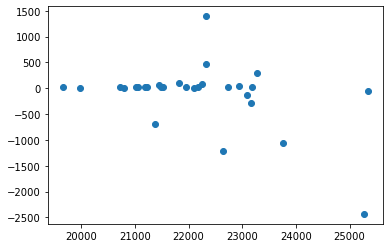

'Model Mean Squared Error: 491590111.63'

In [74]:
mse = mean_squared_error(y_true=y_test, y_pred=preds)
    
residuals = y_test-preds
plt.scatter(residuals, preds)
plt.show()
f'Model Mean Squared Error: {np.round(mse,2)}'

**13a. How did you decide this was your best model? How does your model perform at predicting weekly sales moving forward? Please use the metrics/visuals you included above to support your answer.** 

Answer: I looped through values of p and q to find the best one.

**13b. How might you improve this model?**

Answer: I think a sarimax model would be an improvement.

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: